# Setup

In [88]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, plot_roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [69]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# I. Wrangle Data

In [70]:
def wrangle(filepath):
    # Import CSV
    df = pd.read_csv(DATA_PATH+'burritos/burritos.csv',
                     parse_dates=['Date'],
                     index_col='Date')
    
    # Drop rows with no target
    df.dropna(axis=0, subset=['overall'], inplace=True)
    
    # Create `'great'` column as target
    df['great'] = (df['overall'] >= 4).astype(int)
    
    # Drop `'overall'` col to avoid leakage
    df.drop(columns='overall', inplace=True)
    
    # Drop columns with lots of `NaN` values
    df.dropna(axis=1, thresh=150, inplace=True)
    
    # Drop high-cardinality categorical variables
    threshold = 10
    high_card_cols = [col for col in df.select_dtypes('object').columns 
                      if df[col].nunique() > threshold]
    df.drop(high_card_cols, axis=1, inplace=True)
    
    # Fix binary columns
    binary_cols = ['Beef', 'Pico', 'Guac', 'Cheese']
    for col in binary_cols:
        df[col] = df[col].str.lower().replace('x', 1).fillna(0).astype(int)
    
    return df

df = wrangle(DATA_PATH+'burritos/burritos.csv')

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 2016-01-18 to 2019-08-27
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cost          414 non-null    float64
 1   Hunger        418 non-null    float64
 2   Length        283 non-null    float64
 3   Circum        281 non-null    float64
 4   Volume        281 non-null    float64
 5   Tortilla      421 non-null    float64
 6   Temp          401 non-null    float64
 7   Meat          407 non-null    float64
 8   Fillings      418 non-null    float64
 9   Meat:filling  412 non-null    float64
 10  Uniformity    419 non-null    float64
 11  Salsa         396 non-null    float64
 12  Synergy       419 non-null    float64
 13  Wrap          418 non-null    float64
 14  Rec           231 non-null    object 
 15  Beef          421 non-null    int64  
 16  Pico          421 non-null    int64  
 17  Guac          421 non-null    int64  
 18  Cheese     

In [72]:
df.head()

,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Rec,Beef,Pico,Guac,Cheese,great
Date,,,,,,,,,,,,,,,,,,,,
2016-01-18,6.49,3.0,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,1,1,1,1,0
2016-01-24,5.45,3.5,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,1,1,1,1,0
2016-01-24,4.85,1.5,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,0,1,1,0,0
2016-01-24,5.25,2.0,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,1,1,1,0,0
2016-01-27,6.59,4.0,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,1,1,0,1,1


# II. Split Data

In [73]:
# Split the TV and FM
target = 'great'
y = df[target]
X = df.drop(target, axis=1)

In [74]:
# Split data into training, validation, and test sets
train_mask = X.index.year < 2017
X_train, y_train = X.loc[train_mask], y.loc[train_mask]

validation_mask = X.index.year == 2017
X_val, y_val = X.loc[validation_mask], y.loc[validation_mask]

test_mask = X.index.year > 2017
X_test, y_test = X.loc[test_mask], y.loc[test_mask]

#  III. Establish Baseline

In [75]:
print('Baseline accuracy:', y_train.value_counts(normalize=True).max())

Baseline accuracy: 0.5906040268456376


# IV. Build Models

1. `LogisticRegression`
    
    - `OneHotEncoder`
    - `SimpleImputer`
    - `StandardScaler`

2. `RandomForestClassifier`
    
    - `OrdinalEncoder`
    - `SimpleImputer`

In [76]:
# Model 1: Logistic Regression Model
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='most_frequent'),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train);

/Users/nicholascifuentes-goodbody/.local/share/virtualenvs/DS-Unit-2-Applied-Modeling-CzmiUvG5/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [77]:
# Model 2: Random Forest
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)

model_rf.fit(X_train, y_train);

# V. Check Metrics

**Accuracy**

In [78]:
print('Training Accuracy (LOGR):', model_lr.score(X_train, y_train))
print('Validation Accuracy (LOGR):', model_lr.score(X_val, y_val))

Training Accuracy (LOGR): 0.9093959731543624
Validation Accuracy (LOGR): 0.8


In [79]:
print('Training Accuracy (RF):', model_rf.score(X_train, y_train))
print('Validation Accuracy (RF):', model_rf.score(X_val, y_val))

Training Accuracy (RF): 1.0
Validation Accuracy (RF): 0.8705882352941177


**Precision, Recall, F1 Score**

In [80]:
print('Logistic Regression')
print(classification_report(y_val, model_lr.predict(X_val)))

Logistic Regression
              precision    recall  f1-score   support

           0       0.89      0.72      0.80        47
           1       0.72      0.89      0.80        38

    accuracy                           0.80        85
   macro avg       0.81      0.81      0.80        85
weighted avg       0.82      0.80      0.80        85



In [81]:
print('Random Forest')
print(classification_report(y_val, model_rf.predict(X_val))) # VALIDATION DATA

Random Forest
              precision    recall  f1-score   support

           0       0.89      0.87      0.88        47
           1       0.85      0.87      0.86        38

    accuracy                           0.87        85
   macro avg       0.87      0.87      0.87        85
weighted avg       0.87      0.87      0.87        85



**ROC Curve**

- To evaluate models for binary classification.
- Decide what probability threshold you should use when making your predictions.

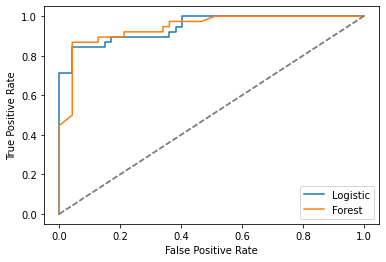

In [87]:
# Use VALIDATION DATA
lr = plot_roc_curve(model_lr, X_val, y_val, label='Logistic')
rf = plot_roc_curve(model_rf, X_val, y_val, ax=lr.ax_, label='Forest')
plt.plot([(0,0), (1,1)], color='grey', linestyle='--')
plt.legend();

In [91]:
print('Logistic: ROC-AUC Score:', roc_auc_score(y_val, model_lr.predict(X_val)))
print('Random Forest: ROC-AUC Score:', roc_auc_score(y_val, model_rf.predict(X_val)))

Logistic: ROC-AUC Score: 0.809070548712206
Random Forest: ROC-AUC Score: 0.870380739081747
